1. На основе учебного ноутбука проведите финальную подготовку данных. Измените количество сегментирующих классов с `16` на `7`:
  - 0_класс - FLOOR
  - 1_класс - CEILING
  - 2_класс - WALL
  - 3_класс - APERTURE, DOOR, WINDOW
  - 4_класс - COLUMN, RAILINGS, LADDER
  - 5_класс - INVENTORY
  - 6_класс - LAMP, WIRE, BEAM, EXTERNAL, BATTERY,
PEOPLE

2. Изучите внимательно особенности `U-net`, определите в чем принципиальное отличие  `U-net `  и   `simpleUnet` из учебного ноутбука.

3. Доработайте `simpleUnet` с учетом особенностей `U-net `. Обучите модель минимум на 20 эпохах и визуализируйте результат.

**Важно!**

Многие эксперименты могут приводить к переполнению ОЗУ в вашем ноутбуке и сброса кода обучения.

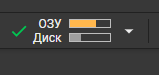

Для предотвращения переполнения ОЗУ может помочь библиотека `gc`. Вставьте строчку `gc.collect()` в цикл ваших экспериментов для сбора и удаления временных данных (кеш).

Перед выполнением задания, пожалуйста, запустите ячейку `Подготовка` ниже:

## Подготовка

### Импорт библиотек

In [ ]:
 # Импортируем модели keras: Model
from tensorflow.keras.models import Model

 # Импортируем стандартные слои keras
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation
from tensorflow.keras.layers import MaxPooling2D, Conv2D, BatchNormalization, UpSampling2D

# Импортируем оптимизатор Adam
from tensorflow.keras.optimizers import Adam

# Импортируем модуль pyplot библиотеки matplotlib для построения графиков
import matplotlib.pyplot as plt

# Импортируем модуль image для работы с изображениями
from tensorflow.keras.preprocessing import image

# Импортируем библиотеку numpy
import numpy as np

# Импортируем методделения выборки
from sklearn.model_selection import train_test_split

# загрузка файлов по HTML ссылке
import gdown

# Для работы с файлами
import os

# Для генерации случайных чисел
import random

import time

# импортируем модель Image для работы с изображениями
from PIL import Image

# очистка ОЗУ
import gc

### Загрузка датасета

грузим и распаковываем архив картинок

In [ ]:
# Загрузка датасета из облака

gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_256x192.zip', None, quiet=False)
#gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_512x384.zip', None, quiet=False)

!unzip -q 'construction_256x192.zip' # распоковываем архив

Downloading...
From: https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_256x192.zip
To: /content/construction_256x192.zip
100%|██████████| 214M/214M [00:11<00:00, 18.6MB/s]


### Предварительная подготовка данных


In [ ]:
# Глобальные параметры

IMG_WIDTH = 192               # Ширина картинки
IMG_HEIGHT = 256              # Высота картинки
NUM_CLASSES = 16              # Задаем количество классов на изображении
TRAIN_DIRECTORY = 'train'     # Название папки с файлами обучающей выборки
VAL_DIRECTORY = 'val'         # Название папки с файлами проверочной выборки

Загрузим оригинальные изображения (код из лекции):

In [ ]:
train_images = [] # Создаем пустой список для хранений оригинальных изображений обучающей выборки
val_images = [] # Создаем пустой список для хранений оригинальных изображений проверочной выборки

cur_time = time.time()  # Засекаем текущее время

# Проходим по всем файлам в каталоге по указанному пути
for filename in sorted(os.listdir(TRAIN_DIRECTORY+'/original')):
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    train_images.append(image.load_img(os.path.join(TRAIN_DIRECTORY+'/original',filename),
                                       target_size=(IMG_WIDTH, IMG_HEIGHT)))

# Отображаем время загрузки картинок обучающей выборки
print ('Обучающая выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в обучающей выборке
print ('Количество изображений: ', len(train_images))

cur_time = time.time() # Засекаем текущее время

# Проходим по всем файлам в каталоге по указанному пути
for filename in sorted(os.listdir(VAL_DIRECTORY+'/original')):
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    val_images.append(image.load_img(os.path.join(VAL_DIRECTORY+'/original',filename),
                                     target_size=(IMG_WIDTH, IMG_HEIGHT)))

# Отображаем время загрузки картинок проверочной выборки
print ('Проверочная выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в проверочной выборке
print ('Количество изображений: ', len(val_images))

Обучающая выборка загружена. Время загрузки: 0.41c
Количество изображений:  1900
Проверочная выборка загружена. Время загрузки: 0.02c
Количество изображений:  100


Загрузим сегментированные изображения (код из лекции):

In [ ]:
train_segments = [] # Создаем пустой список для хранений оригинальных изображений обучающей выборки
val_segments = [] # Создаем пустой список для хранений оригинальных изображений проверочной выборки

cur_time = time.time() # Засекаем текущее время

for filename in sorted(os.listdir(TRAIN_DIRECTORY+'/segment')): # Проходим по всем файлам в каталоге по указанному пути
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    train_segments.append(image.load_img(os.path.join(TRAIN_DIRECTORY+'/segment',filename),
                                       target_size=(IMG_WIDTH, IMG_HEIGHT)))

# Отображаем время загрузки картинок обучающей выборки
print ('Обучающая выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в обучающем наборе сегментированных изображений
print ('Количество изображений: ', len(train_segments))

cur_time = time.time() # Засекаем текущее время

for filename in sorted(os.listdir(VAL_DIRECTORY+'/segment')): # Проходим по всем файлам в каталоге по указанному пути
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    val_segments.append(image.load_img(os.path.join(VAL_DIRECTORY+'/segment',filename),
                                     target_size=(IMG_WIDTH, IMG_HEIGHT)))

# Отображаем время загрузки картинок проверочной выборки
print ('Проверочная выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в проверочном наборе сегментированных изображений
print ('Количество изображений: ', len(val_segments))

Обучающая выборка загружена. Время загрузки: 0.39c
Количество изображений:  1900
Проверочная выборка загружена. Время загрузки: 0.02c
Количество изображений:  100


## Решение

In [ ]:
# Решение

# Служебная функция загрузки выборки изображений из файлов в папке

def load_imageset(folder,   # имя папки
                  subset,   # подмножество изображений - оригинальные или сегментированные
                  title     # имя выборки
                  ):

    # Cписок для хранения изображений выборки
    image_list = []

    # Отметка текущего времени
    cur_time = time.time()

    # Для всех файлов в каталоге по указанному пути:
    for filename in sorted(os.listdir(f'{folder}/{subset}')):

        # Чтение очередной картинки и добавление ее в список изображений требуемого размера
        image_list.append(image.load_img(os.path.join(f'{folder}/{subset}', filename),
                                         target_size=(IMG_WIDTH, IMG_HEIGHT)))

    # Вывод времени загрузки картинок выборки
    print('{} выборка загружена. Время загрузки: {:.2f} с'.format(title,
                                                                  time.time() - cur_time))

    # Вывод количества элементов в выборке
    print('Количество изображений:', len(image_list))

    return image_list

# Функция для просмотра изображений из набора

def show_imageset(image_list,  # выборка изображений
                  n            # количество картинок для просмотра
                  ):

    fig, axs = plt.subplots(1, n, figsize=(25, 10))       # Создание полотна из n графиков

    # Вывод в цикле n случайных изображений
    for i in range(n):
        img = random.choice(image_list)                   # Выборка случайного фото для отображения
        axs[i].axis('off')
        axs[i].imshow(img)                                # Отображение картинки

    plt.show()                                            # Отрисовка изображений

In [ ]:
# Загрузка входных изображений

train_images = load_imageset(TRAIN_DIRECTORY, 'original', 'Обучающая')
val_images = load_imageset(VAL_DIRECTORY, 'original', 'Проверочная')

Обучающая выборка загружена. Время загрузки: 0.60 с
Количество изображений: 1900
Проверочная выборка загружена. Время загрузки: 0.03 с
Количество изображений: 100


In [ ]:
# Загрузка выходных (сегментированных) изображений

train_segments = load_imageset(TRAIN_DIRECTORY, 'segment', 'Обучающая')
val_segments = load_imageset(VAL_DIRECTORY, 'segment', 'Проверочная')

Обучающая выборка загружена. Время загрузки: 0.42 с
Количество изображений: 1900
Проверочная выборка загружена. Время загрузки: 0.01 с
Количество изображений: 100


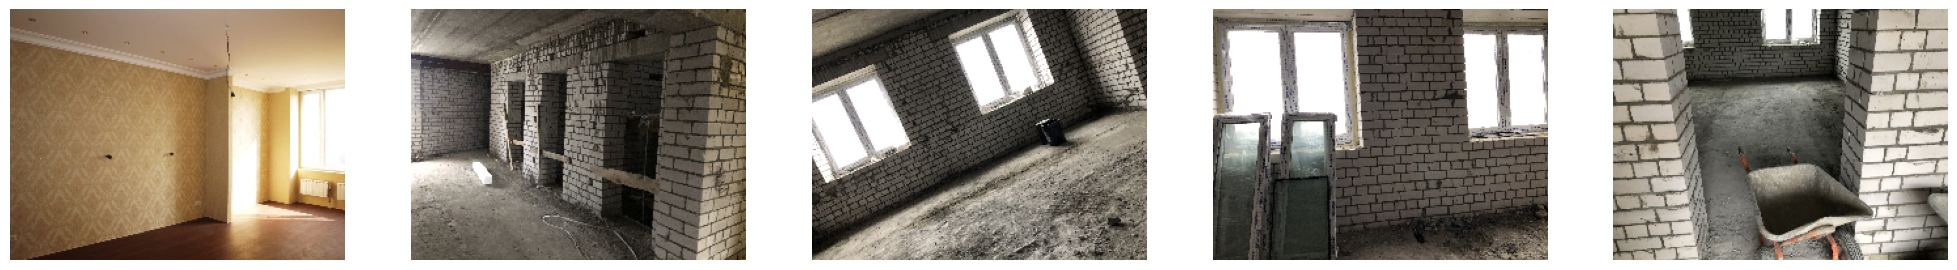

In [ ]:
# Просмотр входных изображений из обучающего набора

show_imageset(train_images, 5)

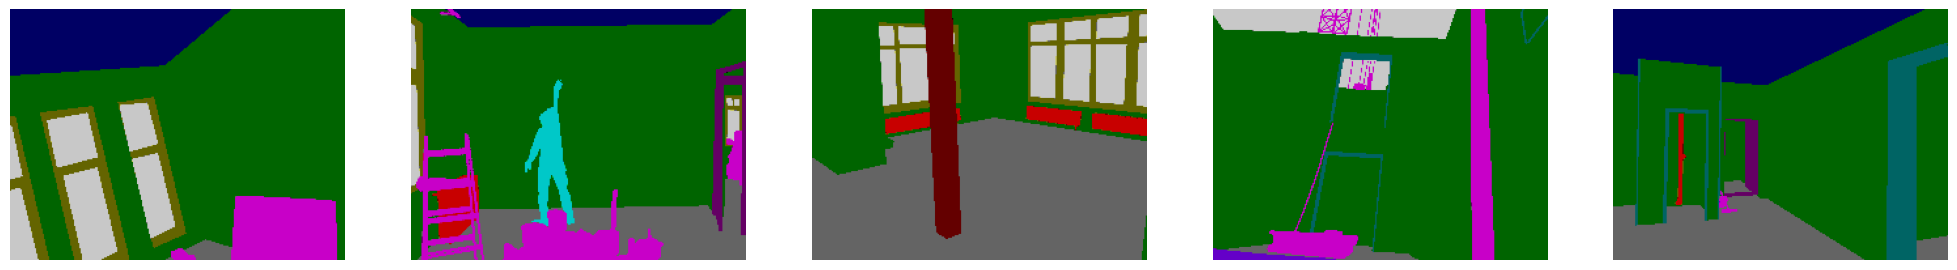

In [ ]:
# Просмотр сегментированных изображений из обучающего набора

show_imageset(train_segments, 5)

In [ ]:
# Цвета пикселов сегментированных изображений

FLOOR = (100, 100, 100)         # Пол (серый)
CEILING = (0, 0, 100)           # Потолок (синий)
WALL = (0, 100, 0)              # Стена (зеленый)
COLUMN = (100, 0, 0)            # Колонна (красный)
APERTURE = (0, 100, 100)        # Проем (темно-бирюзовый)
DOOR = (100, 0, 100)            # Дверь (бордовый)
WINDOW = (100, 100, 0)          # Окно (золотой)
EXTERNAL = (200, 200, 200)      # Внешний мир (светло-серый)
RAILINGS = (0, 200, 0)          # Перила (светло-зеленый)
BATTERY = (200, 0, 0)           # Батареи (светло-красный)
PEOPLE = (0, 200, 200)          # Люди (бирюзовый)
LADDER = (0, 0, 200)            # Лестница (светло-синий)
INVENTORY = (200, 0, 200)       # Инвентарь (розовый)
LAMP = (200, 200, 0)            # Лампа (желтый)
WIRE = (0, 100, 200)            # Провод (голубой)
BEAM = (100, 0, 200)            # Балка (фиолетовый)

CLASS_LABELS = (FLOOR, CEILING, WALL, COLUMN, APERTURE, DOOR, WINDOW, EXTERNAL, RAILINGS, BATTERY, PEOPLE, LADDER, INVENTORY, LAMP, WIRE, BEAM)

CLASS_COUNT = len(CLASS_LABELS)

In [ ]:
y = np.zeros((IMG_WIDTH, IMG_HEIGHT, 1), dtype='uint8')

In [ ]:
sample = np.array(train_segments[10])

for i, cl in enumerate(CLASS_LABELS):
    y[np.where(np.all(sample == CLASS_LABELS[i], axis=-1))] = i

In [ ]:
# Функция преобразования цветного сегментированного изображения в метки классов

def rgb_to_labels(image_list  # список цветных изображений
                 ):

    result = []

    # Для всех картинок в списке:
    for d in image_list:
        sample = np.array(d)
        # Создание пустой 1-канальной картики
        y = np.zeros((IMG_WIDTH, IMG_HEIGHT, 1), dtype='uint8')

        # По всем классам:
        for i, cl in enumerate(CLASS_LABELS):
            # Нахождение 3-х канальных пикселей классов и занесение метки класса
            y[np.where(np.all(sample == CLASS_LABELS[i], axis=-1))] = i

        result.append(y)

    return np.array(result)

# Функция преобразования тензора меток класса в цветное сегметрированное изображение

def labels_to_rgb(image_list  # список одноканальных изображений
                 ):

    result = []

    # Для всех картинок в списке:
    for y in image_list:
        # Создание пустой цветной картики
        temp = np.zeros((IMG_WIDTH, IMG_HEIGHT, 3), dtype='uint8')

        # По всем классам:
        for i, cl in enumerate(CLASS_LABELS):
            # Нахождение пикселов класса и заполнение цветом из CLASS_LABELS[i]
            temp[np.where(np.all(y==i, axis=-1))] = CLASS_LABELS[i]

        result.append(temp)

    return np.array(result)

In [ ]:
# Формирование обучающей выборки

x_train = []                          # Cписок под обучающую выборку

for img in train_images:              # Для всех изображений выборки:
    x = image.img_to_array(img)       # Перевод изображения в numpy-массив формы: высота x ширина x количество каналов
    x_train.append(x)                 # Добавление элемента в x_train

x_train = np.array(x_train)           # Перевод всей выборки в numpy
print(x_train.shape)                  # Форма x_train

(1900, 192, 256, 3)


In [ ]:
# Формирование проверочной выборки

x_val = []                            # Cписок под проверочную выборку

for img in val_images:                # Для всех изображений выборки:
    x = image.img_to_array(img)       # Перевод изображения в numpy-массив формы: высота x ширина x количество каналов
    x_val.append(x)                   # Добавление элемента в x_train

x_val = np.array(x_val)               # Перевод всей выборки в numpy
print(x_val.shape)                    # Форма x_train

(100, 192, 256, 3)


In [ ]:
# Преобразование сегментов в метки классов

y_train = rgb_to_labels(train_segments)
y_val = rgb_to_labels(val_segments)

print(y_train.shape)
print(y_val.shape)

(1900, 192, 256, 1)
(100, 192, 256, 1)


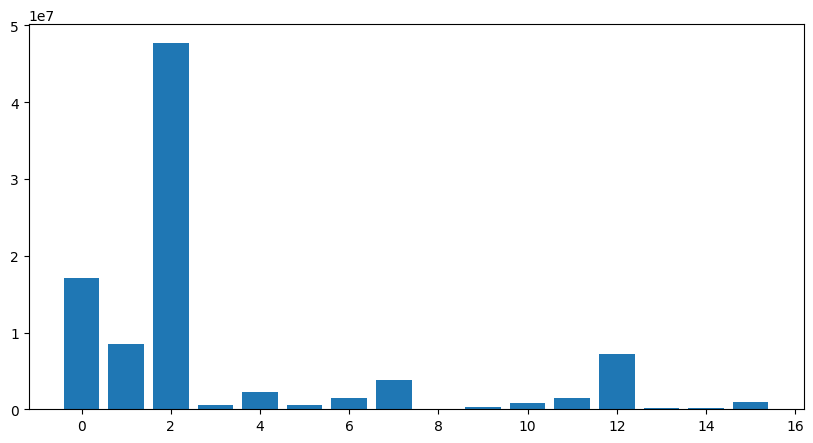

In [ ]:
# Уменьшим число классов до семи.
# Вычисление количества пикселов по всем классам в y_train

pix_count = np.zeros(CLASS_COUNT)
for i in range(CLASS_COUNT):
    pix_count[i] = (y_train == i).sum()

# Отрисовка столбчатой диаграммы наполненности классов

plt.figure(figsize = (10, 5))
plt.bar(np.arange(CLASS_COUNT), pix_count)
plt.show()

In [ ]:
# Перераспределяем классы.

y_train7 = y_train.copy()
y_train7[(y_train7 == 4) & (y_train7 == 5) & (y_train7 == 6)] = 3
y_train7[(y_train7 == 2) & (y_train7 == 8) & (y_train7 == 11)] = 4
y_train7[y_train7 == 12] = 5
y_train7[(y_train7 > 12) & (y_train7 == 7) & (y_train7 == 9) & (y_train7 == 10)] = 6


y_val7 = y_val.copy()
y_val7[(y_val7 == 4) & (y_val7 == 5) & (y_val7 == 6)] = 3
y_val7[(y_val7 == 2) & (y_val7 == 8) & (y_val7 == 11)] = 4
y_val7[y_val7 == 12] = 5
y_val7[(y_val7 > 12) & (y_val7 == 7) & (y_val7 == 9) & (y_val7 == 10)] = 6

##Архитектура U-net

Архитектура U-Net оптимизирована для обеспечения наилучшей сегментации с меньшим количеством обучающих данных. Она построена без полносвязных слоев и относится к типу полностью сверточных сетей (FCNN).

In [ ]:
def unet(class_count,   # количество классов
         input_shape    # форма входного изображения
         ):

    img_input = Input(input_shape)                                          # Создаем входной слой формой input_shape

    ''' Block 1 '''
    x = Conv2D(32, (3, 3), padding='same', name='block1_conv1')(img_input)  # Добавляем Conv2D-слой с 32-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(32, (3, 3), padding='same', name='block1_conv2')(x)          # Добавляем Conv2D-слой с 32-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling2D()(block_1_out)                                         # Добавляем слой MaxPooling2D

    ''' Block 2 '''
    x = Conv2D(64, (3, 3), padding='same', name='block2_conv1')(x)         # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block2_conv2')(x)         # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling2D()(block_2_out)                                         # Добавляем слой MaxPooling2D

    ''' Block 3 '''
    x = Conv2D(128, (3, 3), padding='same', name='block3_conv1')(x)         # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block3_conv2')(x)         # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block3_conv3')(x)         # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_3_out

    x = MaxPooling2D()(block_3_out)                                         # Добавляем слой MaxPooling2D

    ''' Block 4 '''
    x = Conv2D(256, (3, 3), padding='same', name='block4_conv1')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block4_conv2')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block4_conv3')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_4_out
    x = block_4_out

    ''' UP 2 '''
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_3_out])                                       # Объединяем текущий слой со слоем block_3_out
    x = Conv2D(128, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    ''' UP 3 '''
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_2_out])                                       # Объединяем текущий слой со слоем block_2_out
    x = Conv2D(54, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(54, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    ''' UP 4 '''
    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(x)      # Добавляем слой Conv2DTranspose с 32 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_1_out])                                       # Объединяем текущий слой со слоем block_1_out
    x = Conv2D(32, (3, 3), padding='same')(x)                               # Добавляем слой Conv2D с 32 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(32, (3, 3), padding='same')(x)                               # Добавляем слой Conv2D с 32 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(class_count, (3, 3), activation='softmax', padding='same')(x)  # Добавляем Conv2D-Слой с softmax-активацией на class_count-нейронов

    model = Model(img_input, x)                                             # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

    # Возвращаем сформированную модель
    return model

In [ ]:
model_unet = unet(CLASS_COUNT, (IMG_WIDTH, IMG_HEIGHT, 3))

model_unet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 192, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 192, 256, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 192, 256, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 192, 256, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 192, 256, 32)   │          9,248 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 192, 256, 32)   │            128 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 192, 256, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 96, 128, 32)    │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 96, 128, 64)    │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 96, 128, 64)    │            256 │ block2_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 96, 128, 64)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 96, 128, 64)    │         36,928 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 96, 128, 64)    │            256 │ block2_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 96, 128, 64)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 48, 64, 64)     │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 48, 64, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 2,652,400 (10.12 MB)

 Trainable params: 2,648,408 (10.10 MB)

 Non-trainable params: 3,992 (15.59 KB)

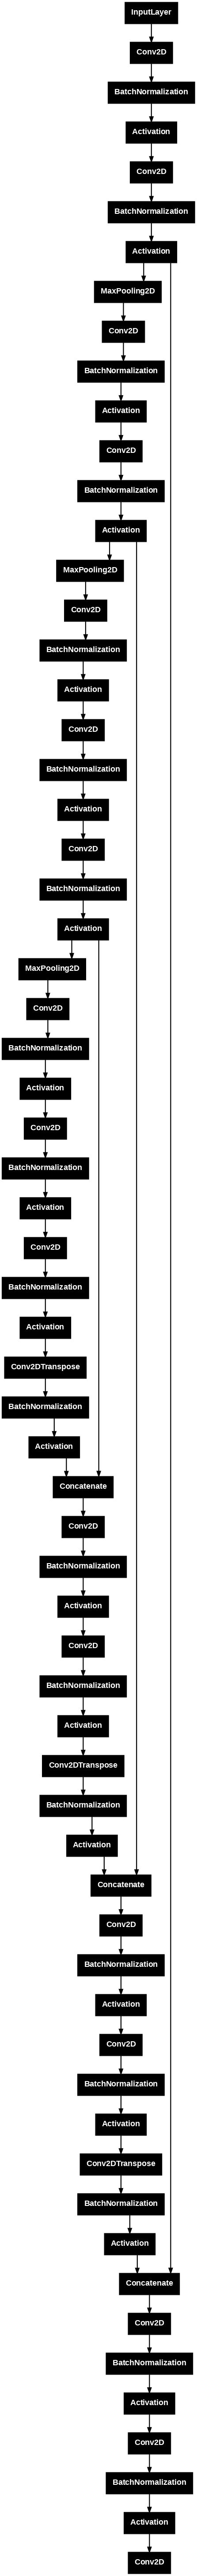

In [ ]:
from tensorflow.keras import utils

utils.plot_model(model_unet, dpi=80)

In [ ]:
history = model_unet.fit(x_train, y_train7,
                         epochs=20, batch_size=32,
                         validation_data=(x_val, y_val7))

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 427ms/step - loss: 1.0115 - sparse_categorical_accuracy: 0.6812 - val_loss: 1.7151 - val_sparse_categorical_accuracy: 0.4245
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 427ms/step - loss: 0.9157 - sparse_categorical_accuracy: 0.7142 - val_loss: 1.4023 - val_sparse_categorical_accuracy: 0.5693
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 425ms/step - loss: 0.8590 - sparse_categorical_accuracy: 0.7296 - val_loss: 1.7805 - val_sparse_categorical_accuracy: 0.4540
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 433ms/step - loss: 0.8112 - sparse_categorical_accuracy: 0.7454 - val_loss: 1.2246 - val_sparse_categorical_accuracy: 0.6395
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 432ms/step - loss: 0.7448 - sparse_categorical_accuracy: 0.7658 - val_loss: 1.2293 - val_sparse_categorical_accuracy: 0.6334
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 433ms/step - loss: 0.7093 - sparse_categorical_accuracy: 0.7764 - val_loss: 1.4057 - val_sparse_categorical_accuracy: 0.592

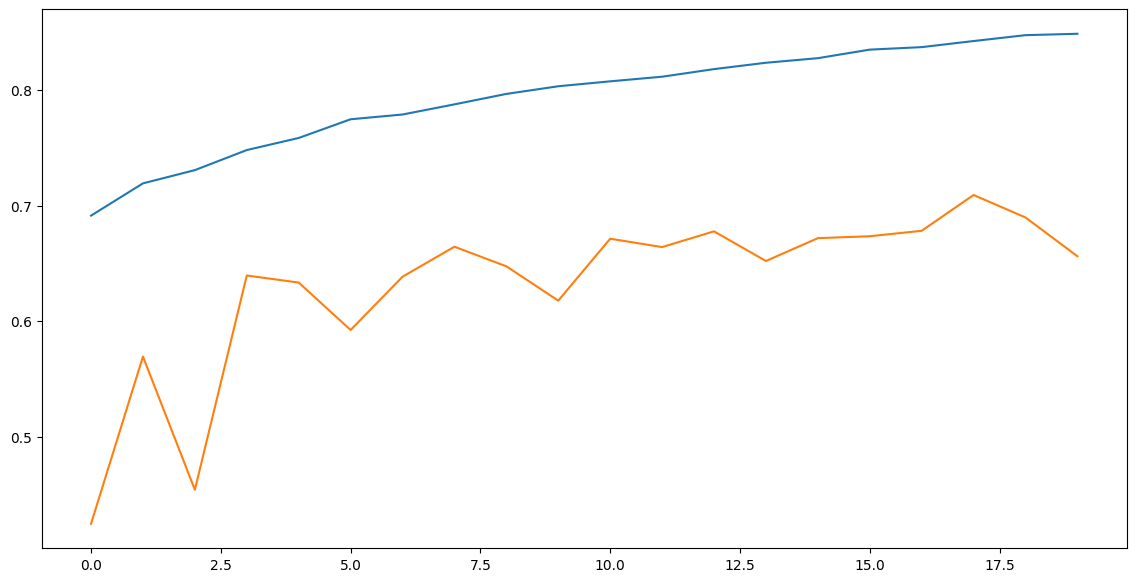

In [ ]:
# Отображение графиков обучения модели

plt.figure(figsize=(14, 7))
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.show()

In [ ]:
# Функция визуализации процесса сегментации изображений

def process_images(model,        # обученная модель
                   count = 1     # количество случайных картинок для сегментации
                   ):

    # Генерация случайного списка индексов в количестве count между (0, len(x_val)
    indexes = np.random.randint(0, len(x_val), count)

    # Вычисление предсказания сети для картинок с отобранными индексами
    predict = np.argmax(model.predict(x_val[indexes]), axis=-1)

    # Подготовка цветов классов для отрисовки предсказания
    orig = labels_to_rgb(predict[..., None])
    fig, axs = plt.subplots(3, count, figsize=(25, 15))

    # Отрисовка результата работы модели
    for i in range(count):
        # Отображение на графике в первой линии предсказания модели
        axs[0, 0].set_title('Результат работы модели:')
        axs[0, i].imshow(orig[i])
        axs[0, i].axis('off')

        # Отображение на графике во второй линии сегментированного изображения из y_val
        axs[1, 0].set_title('Оригинальное сегментированное')
        axs[1, i].imshow(val_segments[indexes[i]])
        axs[1 ,i].axis('off')

        # Отображение на графике в третьей линии оригинального изображения
        axs[2, 0].set_title('Оригинальное изображение')
        axs[2, i].imshow(val_images[indexes[i]])
        axs[2 ,i].axis('off')

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


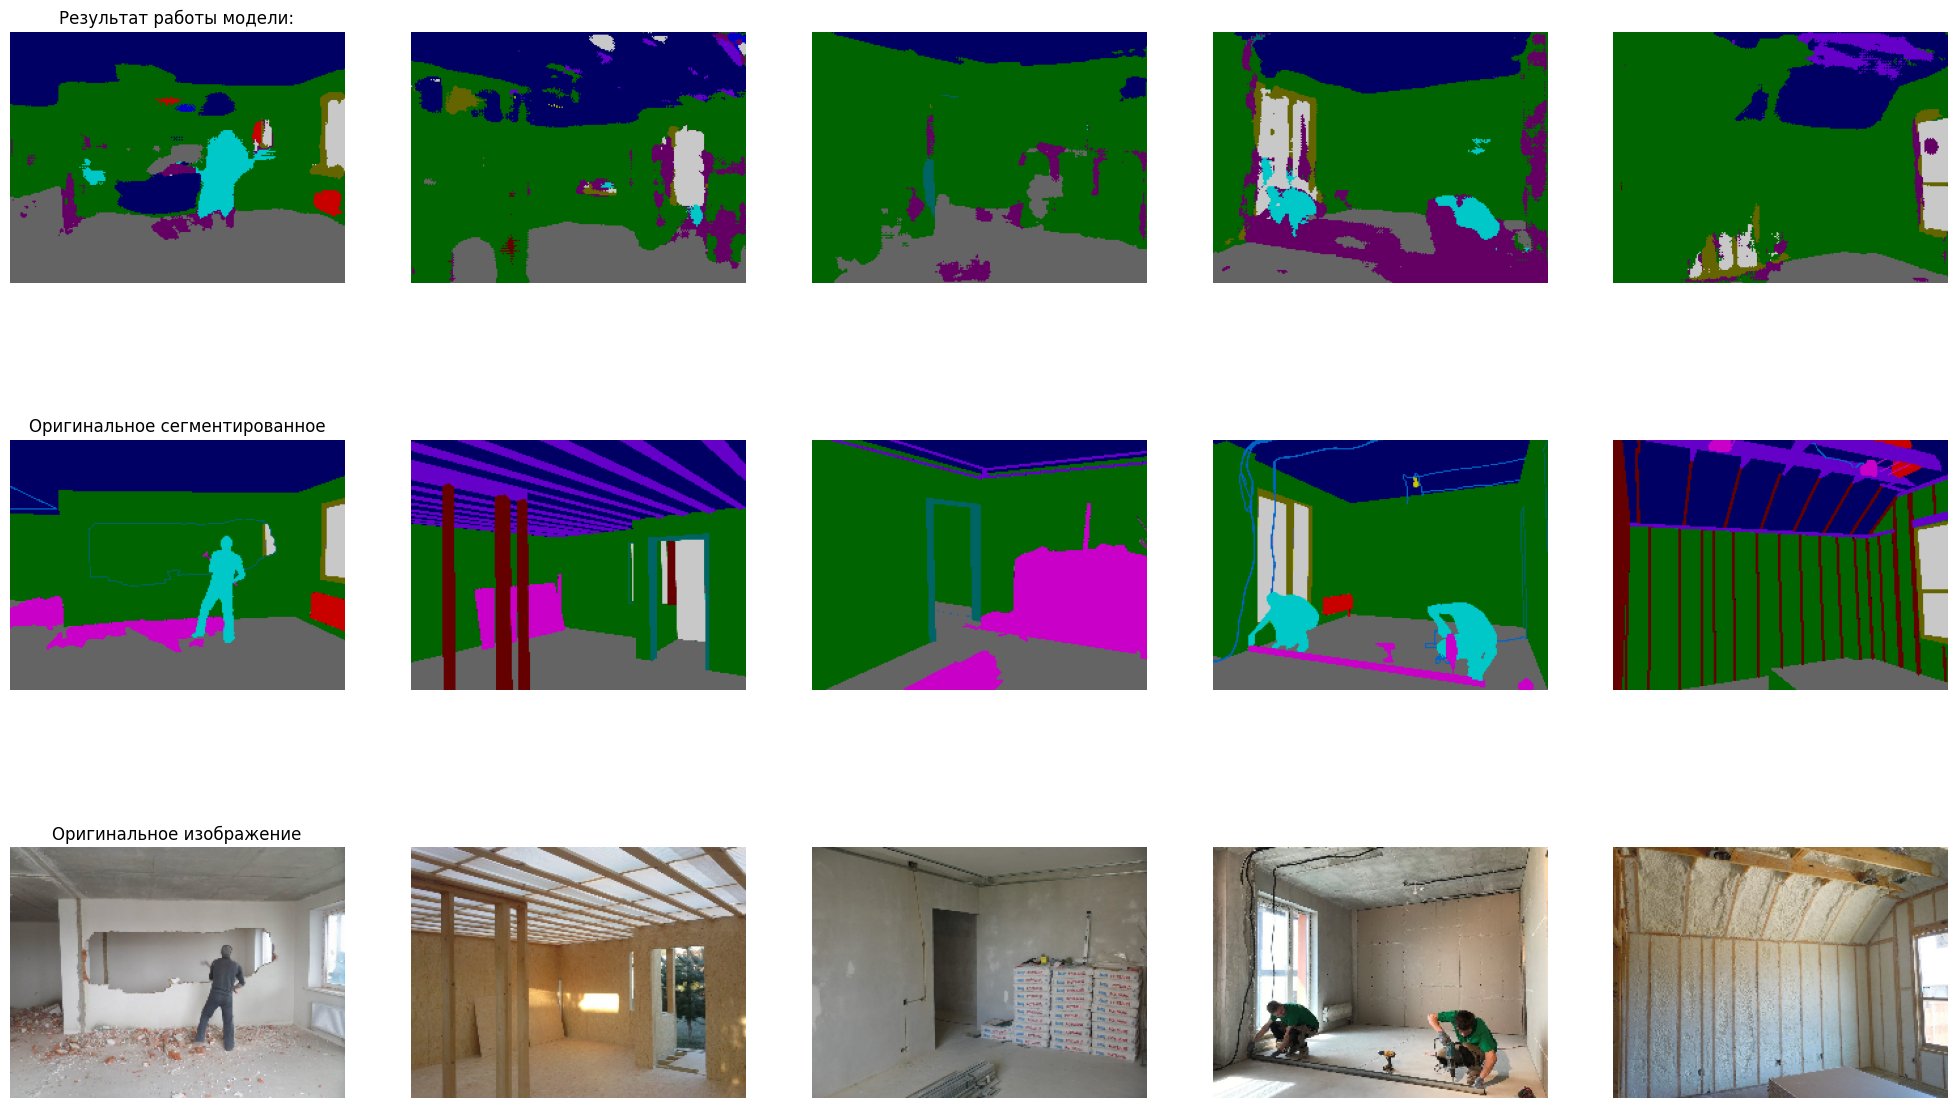

In [ ]:
# Отображение результатов работы модели

process_images(model_unet, 5)

Результат неплох. Нейросеть достаточно уверенно определяет людей, и выходной грацик достаточно хорош.

##Упрощённая архитектура U-net

Упростим архитектуру и проверим, насколько хуже она работает.

В упрощенной архитектуре не используется слой BatchNormalization() по скольку он требует достаточно большие вычислительные мощности. Также, количество уровней и пробросов в сети сокращается всего до двух. Чтобы эффективно сжимать и расжимать картинку при всего двух слоях MaxPooling() и Conv2DTranspose(), мы укажем, что каждый слой меняет размерность не в 2 раза, а в 4.

In [ ]:
def simple_unet(class_count,  # количество классов
                input_shape   # форма входного изображения
                ):

    img_input = Input(input_shape)                                          # Создаем входной слой формой input_shape

    # Block 1
    x = Conv2D(32, (3, 3), padding='same', name='block1_conv1')(img_input)  # Добавляем Conv2D-слой с 32-нейронами
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(32, (3, 3), padding='same', name='block1_conv2')(x)          # Добавляем Conv2D-слой с 32-нейронами
    block_1_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling2D(4)(block_1_out)                                         # Добавляем слой MaxPooling2D чтобы сжать картинку в 4 раза

    # Block 2
    x = Conv2D(64, (3, 3), padding='same', name='block2_conv1')(x)          # Добавляем Conv2D-слой с 64-нейронами
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block2_conv2')(x)          # Добавляем Conv2D-слой с 64-нейронами
    block_2_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling2D(4)(block_2_out)                                         # Добавляем слой MaxPooling2D чтобы сжать картинку в 4 раза

    # UP 1
    x = Conv2DTranspose(64, (4, 4), strides=(4, 4), padding='same')(x)      # Добавляем Conv2DTranspose-слой с 64-нейронами и размером ядра + шага равным 4
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                               # Добавляем Conv2D-слой с 64-нейронами
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                               # Добавляем Conv2D-слой с 64-нейронами
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    # UP 2
    x = Conv2DTranspose(32, (4, 4), strides=(4, 4), padding='same')(x)      # Добавляем Conv2DTranspose-слой с 32-нейронами и размером ядра + шага равным 4
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(32, (3, 3), padding='same')(x)                               # Добавляем Conv2D-слой с 32-нейронами
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(32, (3, 3), padding='same')(x)                               # Добавляем Conv2D-слой с 32-нейронами
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(class_count,(3,3), activation='softmax', padding='same')(x)  # Добавляем Conv2D-Слой с softmax-активацией на class_count-нейронов

    model = Model(img_input, x)                                             # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

    # Возвращаем сформированную модель
    return model

In [ ]:
# Создание упрощенной модели и вывод сводки

model_simple_unet = simple_unet(CLASS_COUNT,
                                (IMG_WIDTH, IMG_HEIGHT, 3))

model_simple_unet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 192, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 192, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_19 (Activation)           │ (None, 192, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 192, 256, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_20 (Activation)           │ (None, 192, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 48, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 48, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_21 (Activation)           │ (None, 48, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 48, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_22 (Activation)           │ (None, 48, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 12, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 48, 64, 64)          │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_23 (Activation)           │ (None, 48, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 48, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_24 (Activation)           │ (None, 48, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 48, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_25 (Activation)           │ (None, 48, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 192, 256, 32)        │          32,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_26 (Activation)           │ (None, 192, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 192, 256, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_27 (Activation)           │ (None, 192, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 260,944 (1019.31 KB)

 Trainable params: 260,944 (1019.31 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Обучение модели

history = model_simple_unet.fit(x_train, y_train7,
                                epochs=20, batch_size=32,
                                validation_data=(x_val, y_val7))

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 64s 315ms/step - loss: 2.0022 - sparse_categorical_accuracy: 0.4332 - val_loss: 1.9146 - val_sparse_categorical_accuracy: 0.4584
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 28s 190ms/step - loss: 1.6171 - sparse_categorical_accuracy: 0.5207 - val_loss: 1.7621 - val_sparse_categorical_accuracy: 0.5092
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 189ms/step - loss: 1.4721 - sparse_categorical_accuracy: 0.5560 - val_loss: 1.6278 - val_sparse_categorical_accuracy: 0.5179
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 190ms/step - loss: 1.2802 - sparse_categorical_accuracy: 0.6035 - val_loss: 1.4715 - val_sparse_categorical_accuracy: 0.5581
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 192ms/step - loss: 1.1139 - sparse_categorical_accuracy: 0.6463 - val_loss: 1.4250 - val_sparse_categorical_accuracy: 0.5699
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 195ms/step - loss: 1.0649 - sparse_categorical_accuracy: 0.6621 - val_loss: 1.3849 - val_sparse_categorical_accuracy: 0.589

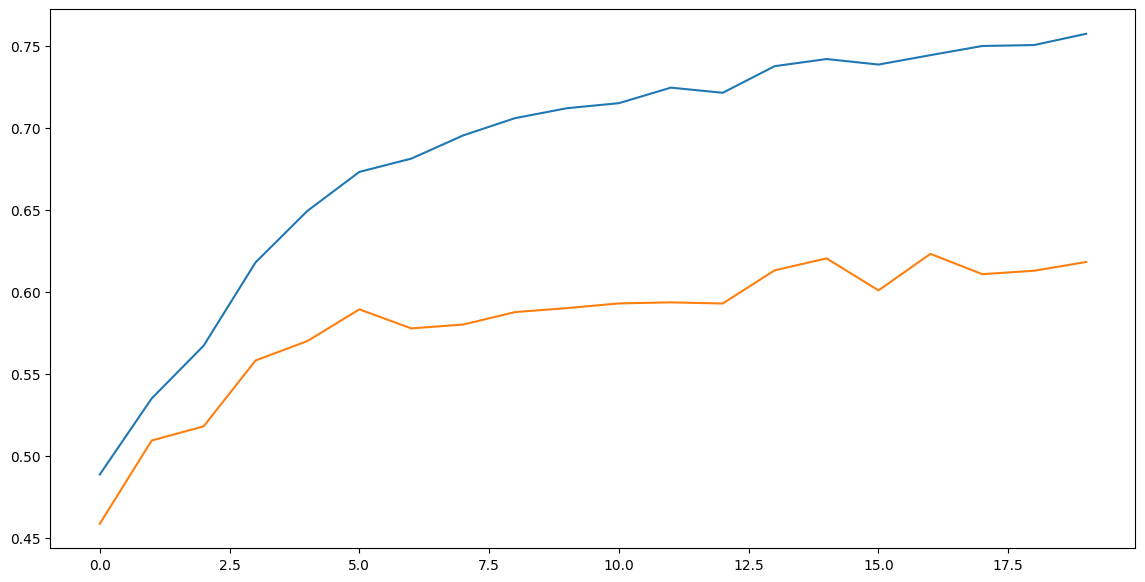

In [ ]:
# Отображение графиков обучения модели

plt.figure(figsize=(14, 7))
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


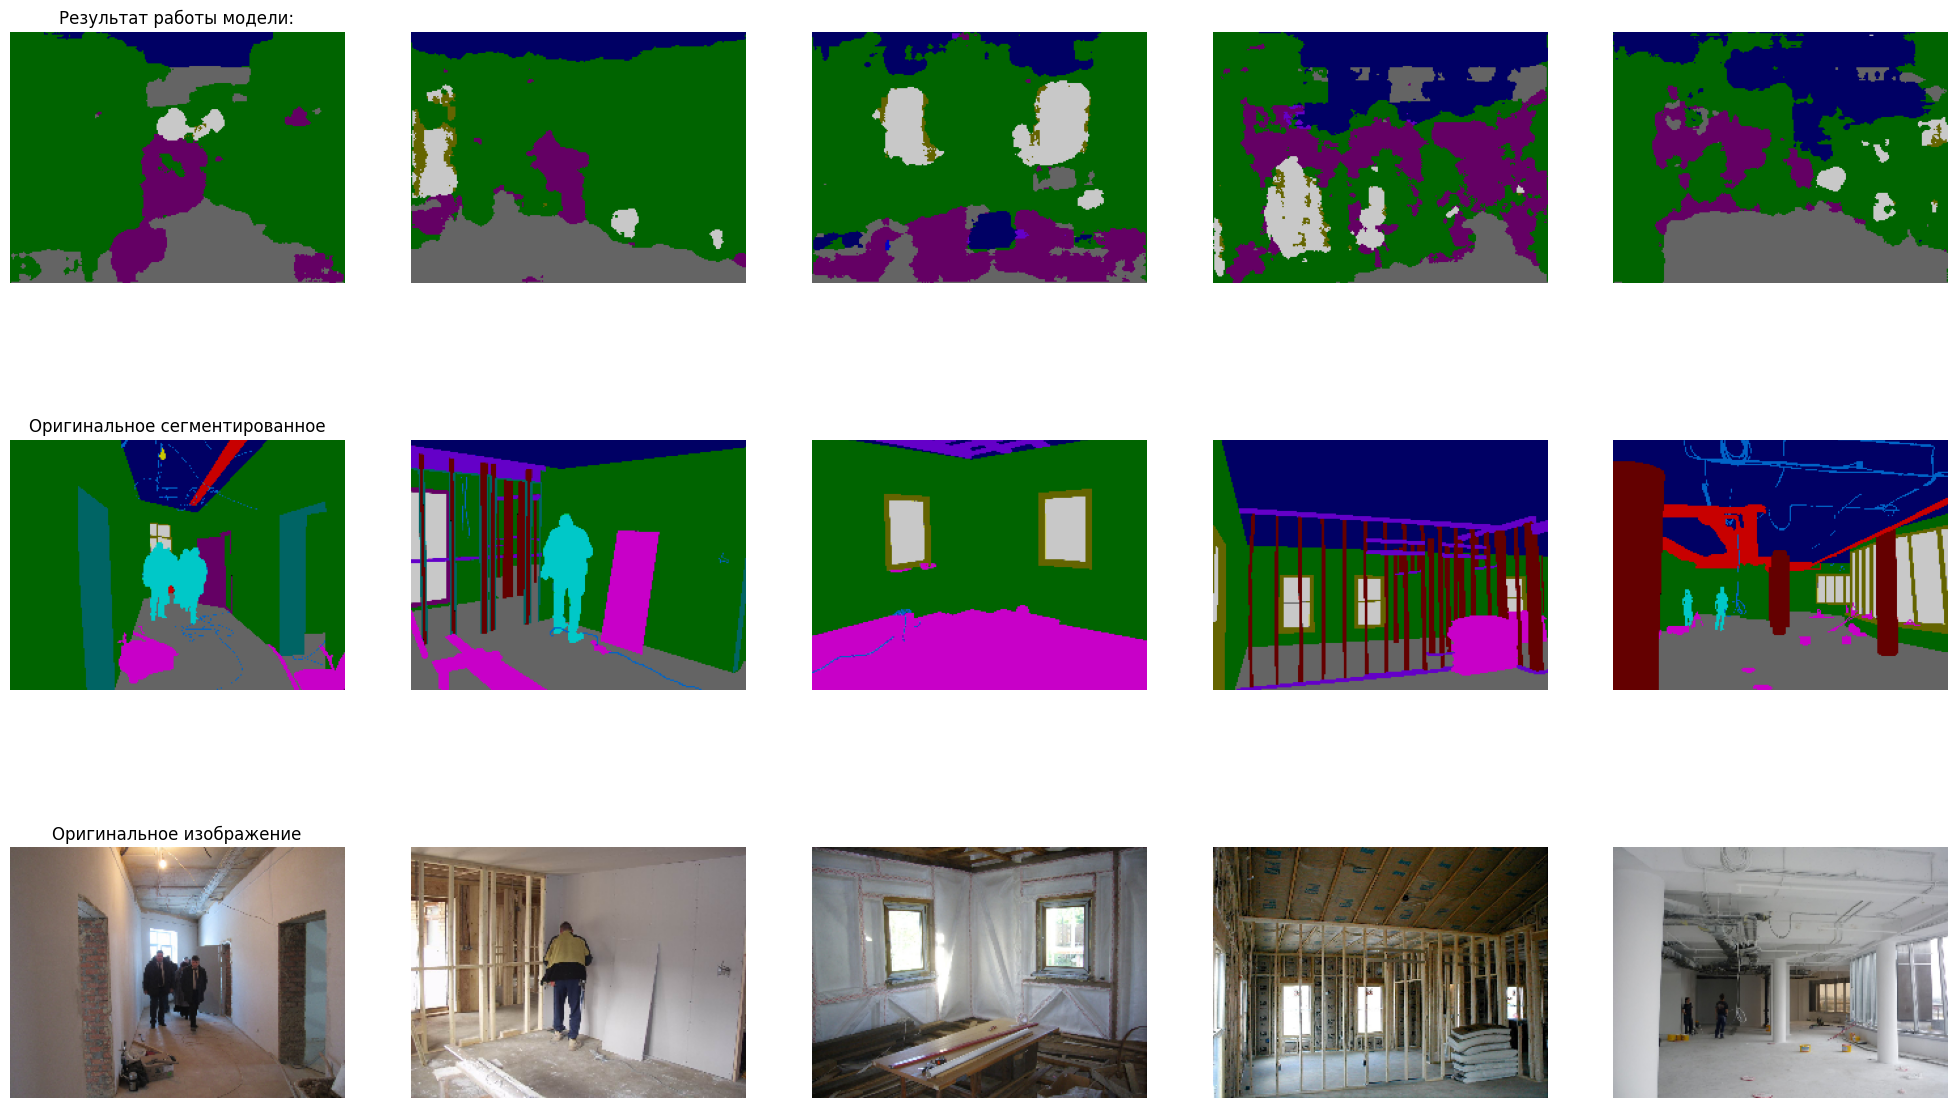

In [ ]:
# Отображение результатов работы модели

process_images(model_simple_unet, 5)

Нейросеть выдала неплохой график, но определение людей резко упало.
Попробуем усложнить структуру.

##Расширенная архитектура U-net

In [ ]:
from tensorflow.keras import utils


In [ ]:
# Соберем нейросеть

def masked_unet(class_count,  # количество классов
                input_shape   # форма входного изображения
                ):

    img_input = Input(input_shape)                                              # Создаем входной слой формой input_shape

    # Block 1
    x = Conv2D(16, (3, 3), padding='same', name='block1_conv1')(img_input)      # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(16, (3, 3), padding='same', name='block1_conv2')(x)              # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                         # Добавляем слой Activation и запоминаем в переменной block_1_out

    block_1_out_mask = Conv2D(16, (1, 1), padding='same')(block_1_out)          # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_1_out_mask

    x = MaxPooling2D()(block_1_out)                                             # Добавляем слой MaxPooling2D

    # Block 2
    x = Conv2D(32, (3, 3), padding='same', name='block2_conv1')(x)             # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(32, (3, 3), padding='same', name='block2_conv2')(x)             # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                         # Добавляем слой Activation и запоминаем в переменной block_2_out

    block_2_out_mask = Conv2D(32, (1, 1), padding='same')(block_2_out)         # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_2_out_mask

    x = MaxPooling2D()(block_2_out)                                             # Добавляем слой MaxPooling2D

    # Block 3
    x = Conv2D(64, (3, 3), padding='same', name='block3_conv1')(x)             # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block3_conv2')(x)             # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block3_conv3')(x)             # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                         # Добавляем слой Activation и запоминаем в переменной block_3_out

    block_3_out_mask = Conv2D(64, (1, 1), padding='same')(block_3_out)          # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_3_out_mask

    x = MaxPooling2D()(block_3_out)                                             # Добавляем слой MaxPooling2D

     # Block 4
    x = Conv2D(128, (3, 3), padding='same', name='block4_conv1')(x)             # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block4_conv2')(x)             # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block4_conv3')(x)             # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                         # Добавляем слой Activation и запоминаем в переменной block_4_out

    block_4_out_mask = Conv2D(128, (1, 1), padding='same')(block_4_out)         # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_4_out_mask

    x = MaxPooling2D()(block_4_out)                                             # Добавляем слой MaxPooling2D

    # Block 5
    x = Conv2D(128, (3, 3), padding='same', name='block5_conv1')(x)             # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block5_conv2')(x)             # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block5_conv3')(x)             # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    for_pretrained_weight = MaxPooling2D()(x)                                   # Добавляем слой MaxPooling2D

    # UP 1
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)         # Добавляем слой Conv2DTranspose с 512 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = concatenate([x, block_4_out, block_4_out_mask])                         # Объединяем текущий слой со слоем block_4_out и слоем-маской block_4_out_mask
    x = Conv2D(128, (3, 3), padding='same')(x)                                  # Добавляем слой Conv2D с 512 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same')(x)                                  # Добавляем слой Conv2D с 512 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    # UP 2
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)          # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = concatenate([x, block_3_out, block_3_out_mask])                         # Объединяем текущий слой со слоем block_3_out и слоем-маской block_3_out_mask
    x = Conv2D(64, (3, 3), padding='same')(x)                                   # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                                   # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    # UP 3
    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(x)          # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = concatenate([x, block_2_out, block_2_out_mask])                         # Объединяем текущий слой со слоем block_2_out и слоем-маской block_2_out_mask
    x = Conv2D(32, (3, 3), padding='same')(x)                                   # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(32, (3, 3), padding='same')(x)                                   # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    # UP 4
    x = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(x)          # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = concatenate([x, block_1_out, block_1_out_mask])                         # Объединяем текущий слой со слоем block_1_out и слоем-маской block_1_out_mask
    x = Conv2D(16, (3, 3), padding='same')(x)                                   # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(16, (3, 3), padding='same')(x)                                   # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(class_count, (3, 3), activation='softmax', padding='same')(x)    # Добавляем Conv2D-Слой с softmax-активацией на class_count-нейронов

    model = Model(img_input, x)                                                 # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

    # Возвращаем сформированную модель
    return model

In [ ]:
# Создание расширенной модели и вывод сводки

model_masked_unet = masked_unet(CLASS_COUNT,
                                (IMG_WIDTH, IMG_HEIGHT,3))

model_masked_unet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 192, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 192, 256, 16)   │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 192, 256, 16)   │             64 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 192, 256, 16)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 192, 256, 16)   │          2,320 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 192, 256, 16)   │             64 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 192, 256, 16)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 96, 128, 16)    │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 96, 128, 32)    │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 96, 128, 32)    │            128 │ block2_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 96, 128, 32)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 96, 128, 32)    │          9,248 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 96, 128, 32)    │            128 │ block2_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 96, 128, 32)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 48, 64, 32)     │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 48, 64, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 1,844,832 (7.04 MB)

 Trainable params: 1,841,280 (7.02 MB)

 Non-trainable params: 3,552 (13.88 KB)

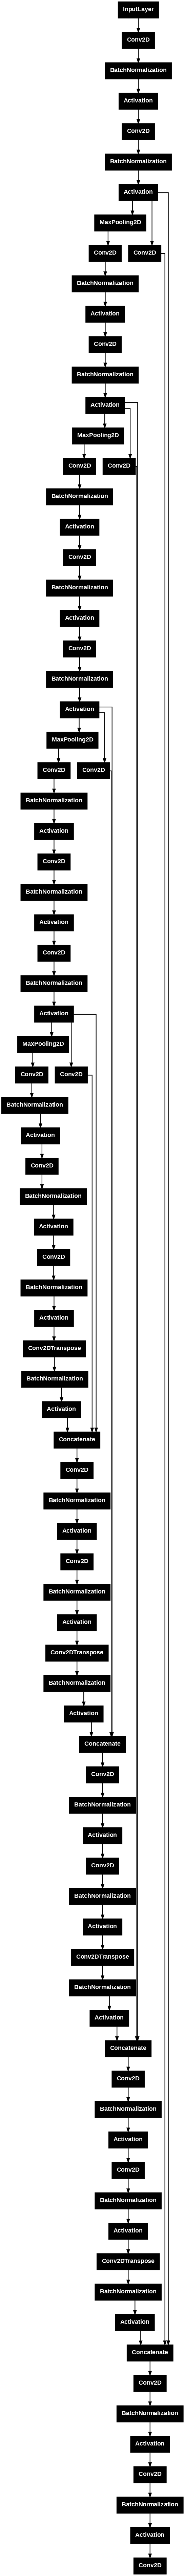

In [ ]:
utils.plot_model(model_masked_unet, dpi=80)

In [ ]:
# Обучение модели

history = model_masked_unet.fit(x_train, y_train7,
                                epochs=20, batch_size=16,
                                validation_data=(x_val, y_val7))

Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1654s 14s/step - loss: 1.9472 - sparse_categorical_accuracy: 0.3916 - val_loss: 2.2144 - val_sparse_categorical_accuracy: 0.2271
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1680s 14s/step - loss: 1.0668 - sparse_categorical_accuracy: 0.6752 - val_loss: 1.5359 - val_sparse_categorical_accuracy: 0.5288
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1668s 14s/step - loss: 0.9301 - sparse_categorical_accuracy: 0.7199 - val_loss: 1.2708 - val_sparse_categorical_accuracy: 0.6120
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1616s 14s/step - loss: 0.9032 - sparse_categorical_accuracy: 0.7252 - val_loss: 1.2711 - val_sparse_categorical_accuracy: 0.6512
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1663s 14s/step - loss: 0.8405 - sparse_categorical_accuracy: 0.7422 - val_loss: 1.1835 - val_sparse_categorical_accuracy: 0.6471
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1638s 14s/step - loss: 0.7671 - sparse_categorical_accuracy: 0.7642 - val_loss: 1.1503 - val_sparse_categorical_acc

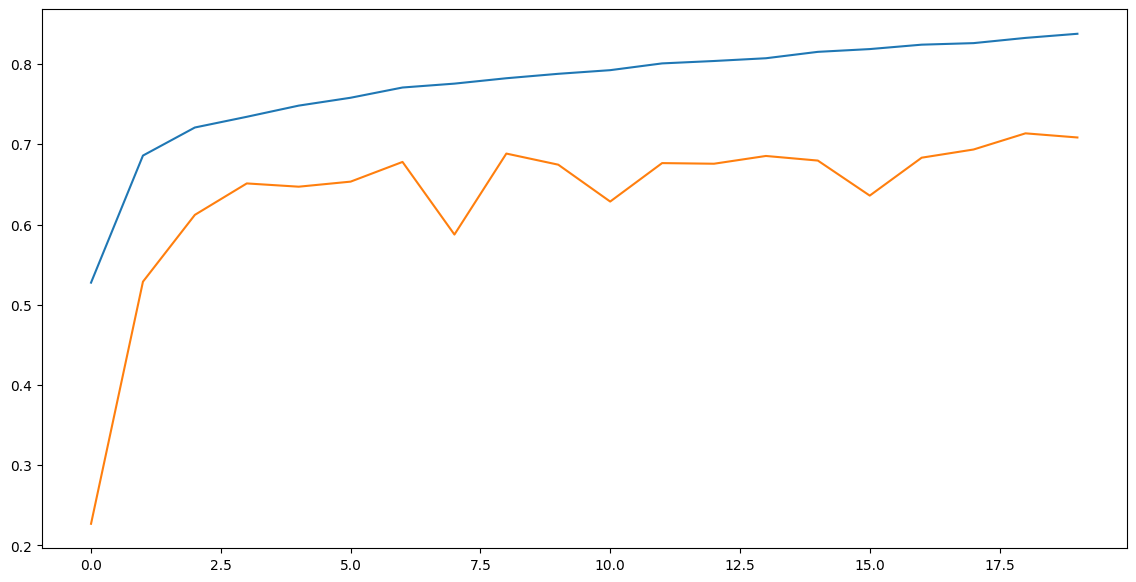

In [ ]:
# Отображение графиков обучения модели

plt.figure(figsize=(14, 7))
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


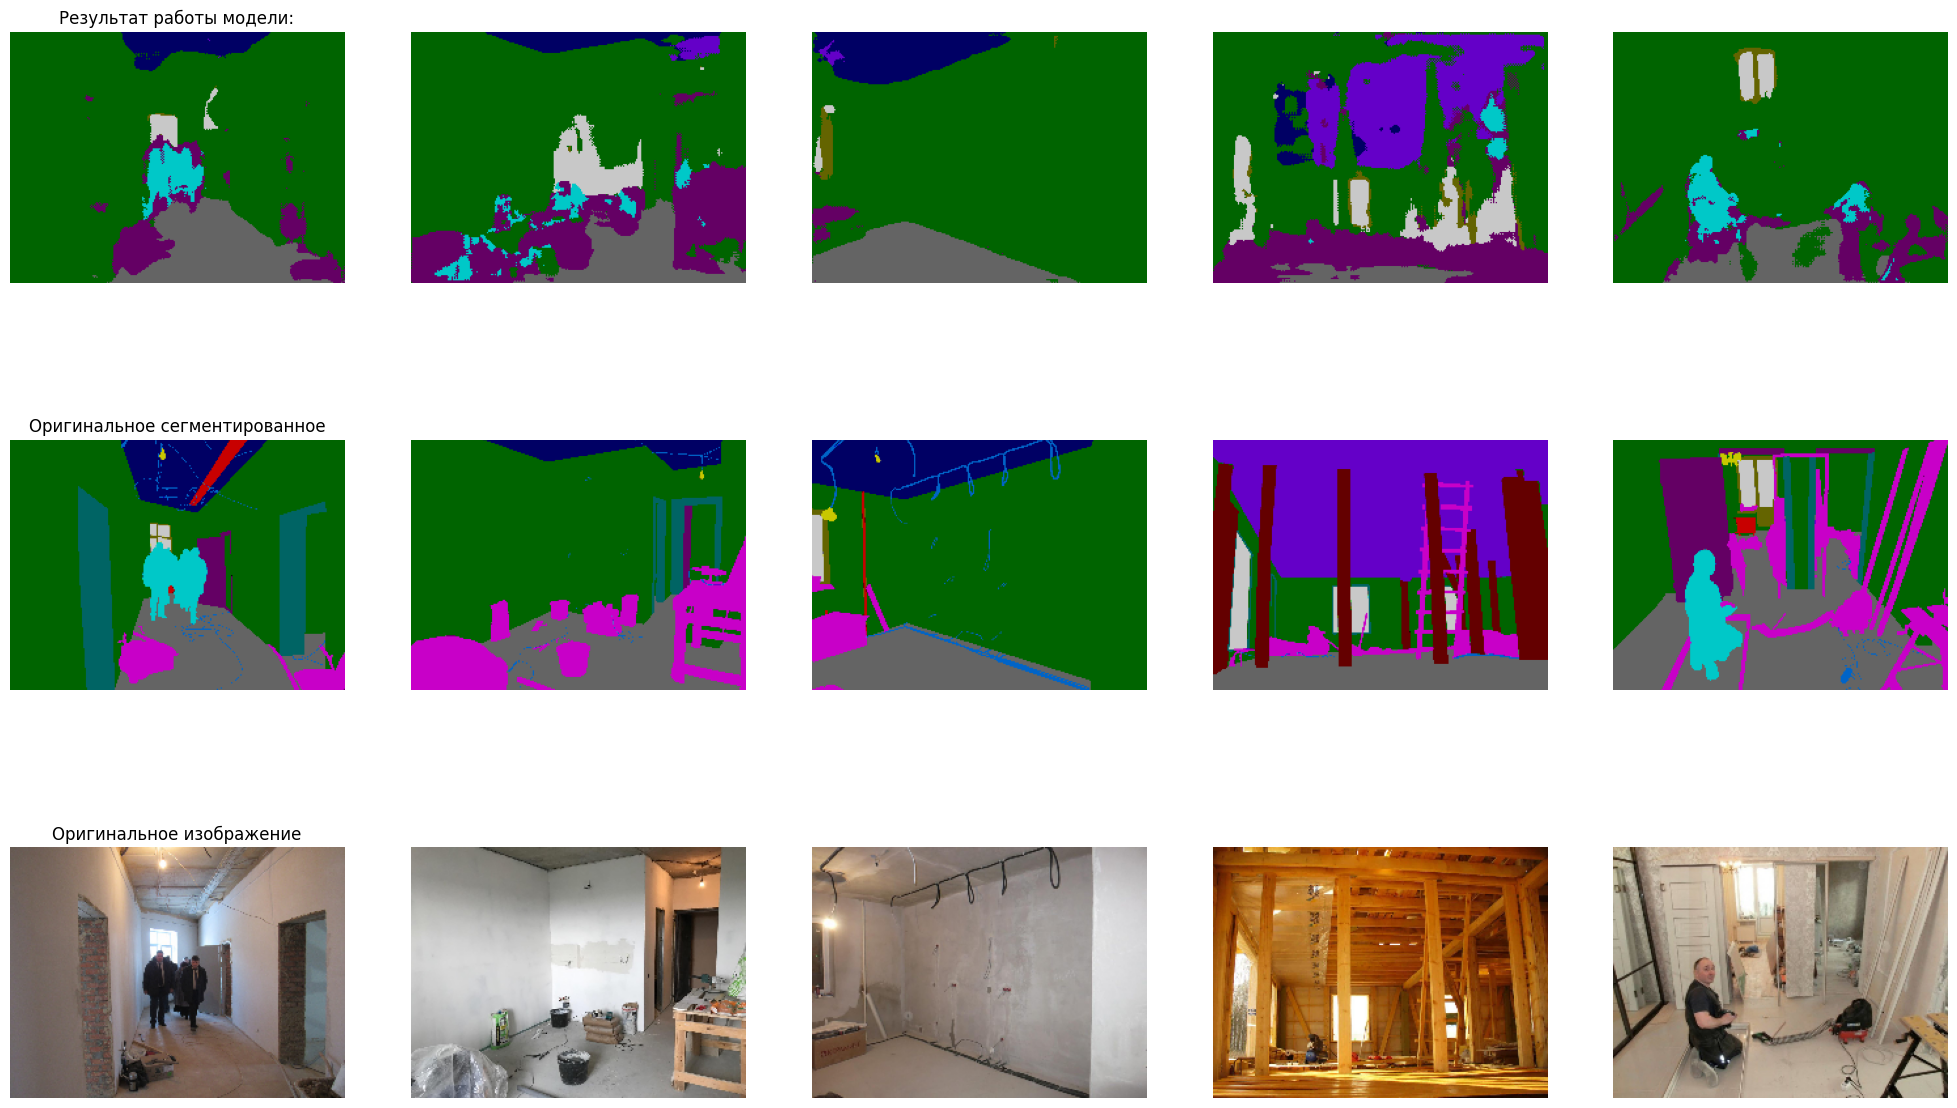

In [ ]:
# Отображение результатов работы модели

process_images(model_masked_unet, 5)

График очень неплох. Люди определяются достаточно уверенно. Эту НС можно обучать дальше, но попробуем некоторую альтернативу.
Создадим упрощенный вариант с функцией Leaky ReLU и одним пробросом.

In [ ]:
from tensorflow.keras.layers import UpSampling2D, LeakyReLU

def unet_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Кодировщик
    c1 = Conv2D(64, (3, 3), padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = LeakyReLU(alpha=0.01)(c1)
    c1 = Conv2D(64, (3, 3), padding='same')(c1)
    c1 = BatchNormalization()(c1)
    c1 = LeakyReLU(alpha=0.01)(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    # Декодер
    u2 = UpSampling2D((2, 2))(p1)
    c2 = concatenate([u2, c1])
    c2 = Conv2D(64, (3, 3), padding='same')(c2)
    c2 = BatchNormalization()(c2)
    c2 = LeakyReLU(alpha=0.01)(c2)
    c2 = Conv2D(64, (3, 3), padding='same')(c2)
    c2 = BatchNormalization()(c2)
    c2 = LeakyReLU(alpha=0.01)(c2)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c2)

    model = Model(inputs, outputs)
    return model

# Дефинируем параметры модели
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
model = unet_model(input_shape, CLASS_COUNT)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


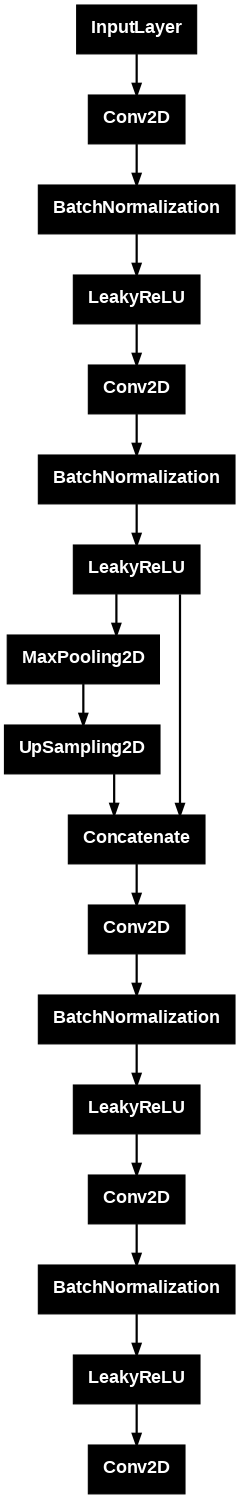

In [ ]:
utils.plot_model(model, dpi=80)

In [ ]:
history = model_unet.fit(x_train, y_train7,
                         epochs=20, batch_size=32,
                         validation_data=(x_val, y_val7))

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 429ms/step - loss: 0.4571 - sparse_categorical_accuracy: 0.8515 - val_loss: 1.1591 - val_sparse_categorical_accuracy: 0.6556
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 430ms/step - loss: 0.4390 - sparse_categorical_accuracy: 0.8566 - val_loss: 1.0201 - val_sparse_categorical_accuracy: 0.6995
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 427ms/step - loss: 0.4258 - sparse_categorical_accuracy: 0.8605 - val_loss: 1.0338 - val_sparse_categorical_accuracy: 0.7018
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 427ms/step - loss: 0.4061 - sparse_categorical_accuracy: 0.8658 - val_loss: 1.1176 - val_sparse_categorical_accuracy: 0.6632
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 432ms/step - loss: 0.4029 - sparse_categorical_accuracy: 0.8679 - val_loss: 1.1139 - val_sparse_categorical_accuracy: 0.6769
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 433ms/step - loss: 0.4018 - sparse_categorical_accuracy: 0.8689 - val_loss: 1.0030 - val_sparse_categorical_accuracy: 0.695

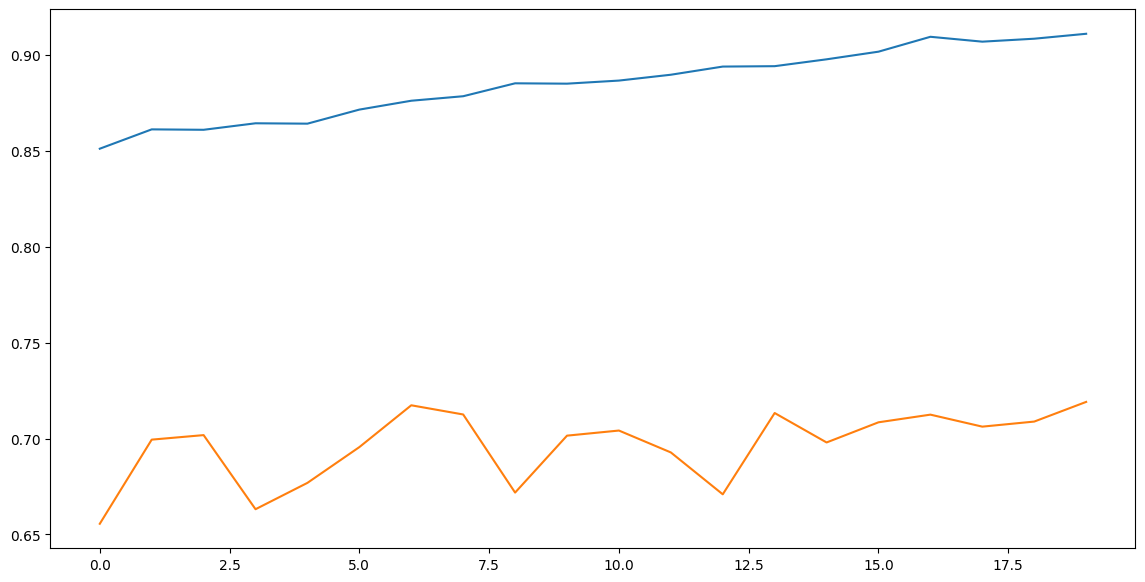

In [ ]:
# Отображение графиков обучения модели

plt.figure(figsize=(14, 7))
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


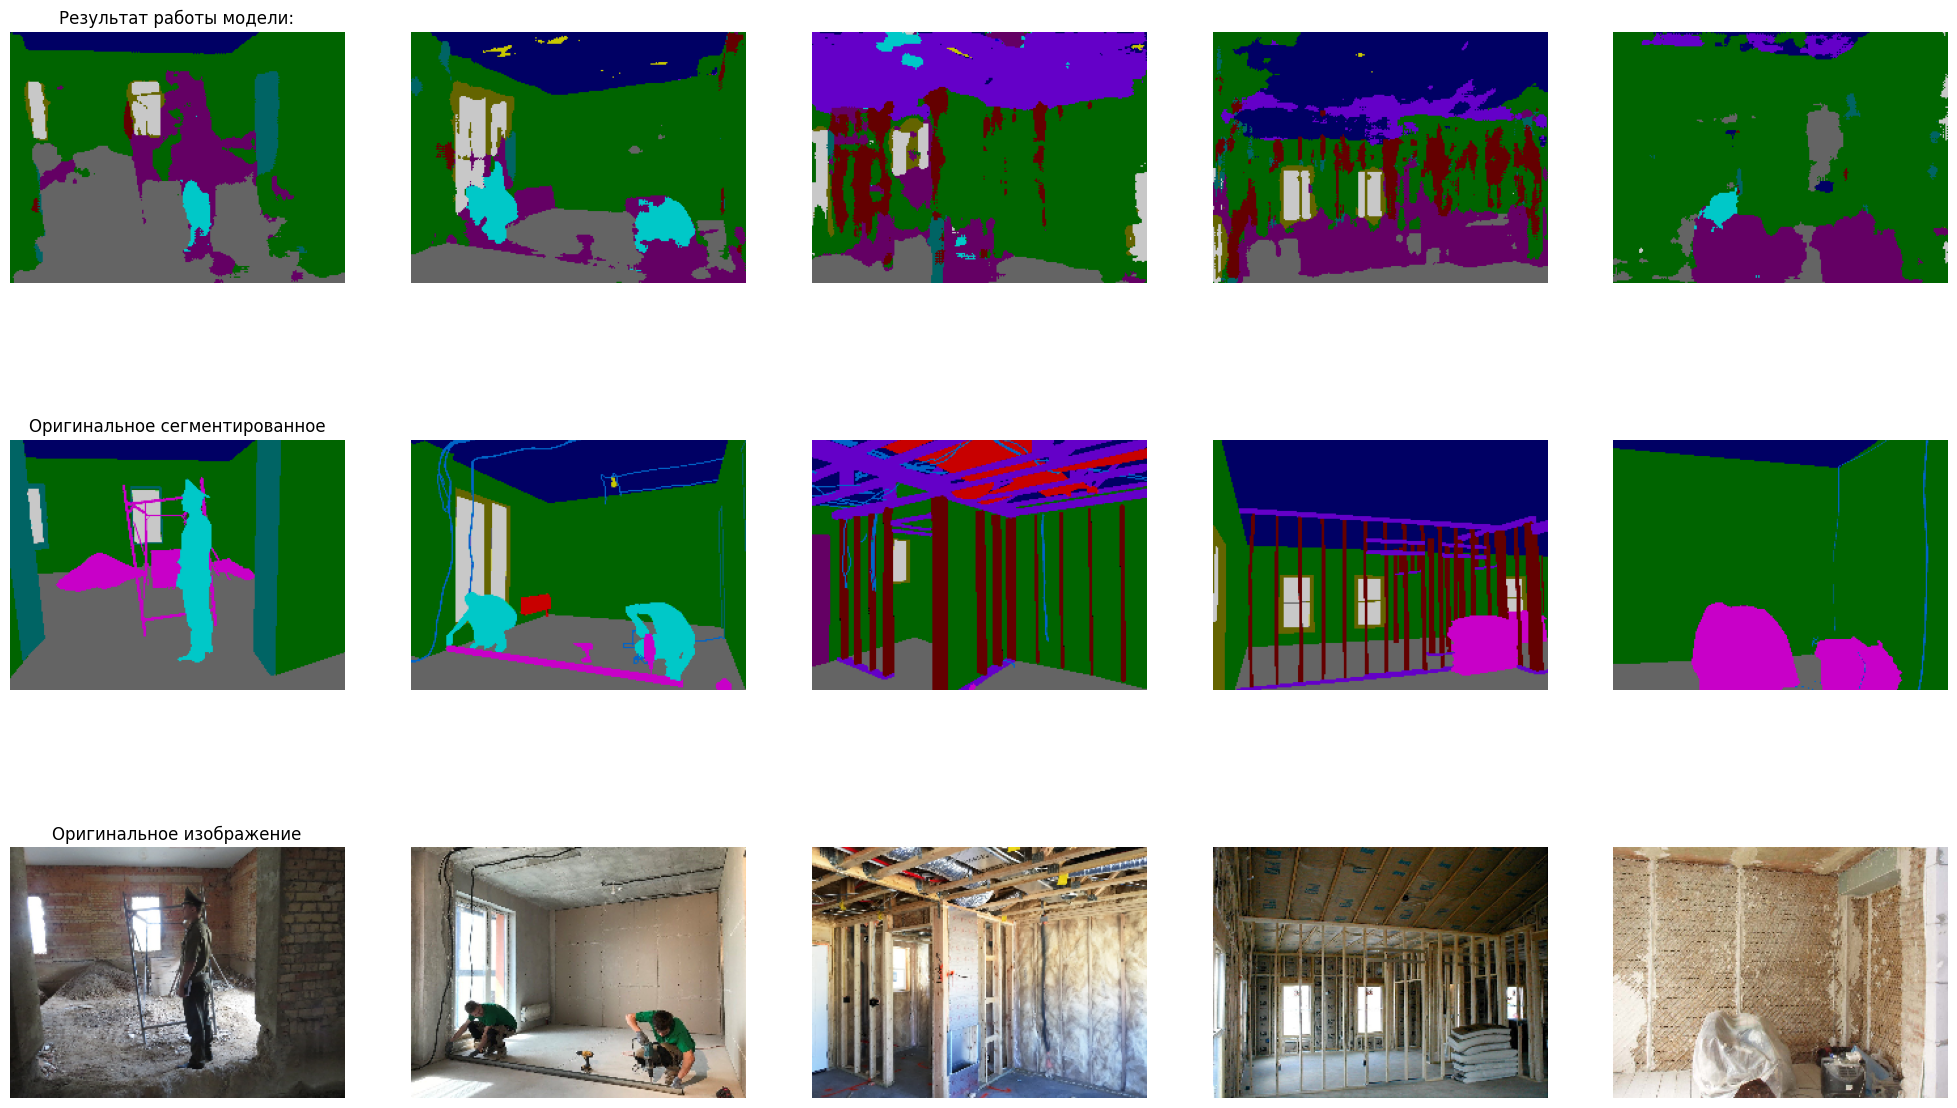

In [ ]:
process_images(model_unet, 5)

Результат очень хорош, несмотря на небольшую базу и мелое количество этох.
Лучшая нейросеть на этом этапе...